# BDC Option Strategy

## Outline
### 1. Construct Option Collar
### 2. Data Preprocessing
### 3. Bounded Option Optimization
### 4. Unbounded Option Optimization

## Construction Option Collar:

1. Give a "moneyness" threshold, find a collar for each asset in the replicating portfolio
2. Option collar strategy is a linear combination of OTM calls and puts such that the weighted average strike is the "moneyness strike"
3. Put leg and call leg are assumed to be 100 contracts (10,000 shares underlying)
    * This avoids purchasing fractional option contracts
    * Solver is implemented to efficiently find linear combination. This is necessary since you can only assume to buy or sell contracts for a contracts which have crossed the spread
    * Solver takes too long when no upperbound on total contracts is specified
4. All contracts have 1 month-until expiration for monthly rebalancing and contracts are left to naturally expire

Notes: 

* I use the close price from QUANDL data because the adjusted close does not align with option strikes and would have to be manually calcualted for all dividends and stock splits

* I initially wanted to also delta hedge this collar strategy but it already acrues a fair amount of transaction costs and does a good job hedging out large movements in replicating assets

Future Considerations:

* Test different thresholds for "moneyness", contract expiration, rebalancing

* Fix the code to update after each previous contract expirary date (currently it only jumps a number of dates ahead)

* Incorporate optimal hedge ratio to proportionally weight the collar for each asset

* Fix statistics (I only did a very small analysis)


## 2. Data Preprocessing

### Imports

In [24]:
import os
import datetime
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB

In [25]:
api_key = os.environ.get('QUANDL_API_KEY')

In [26]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r"C:\Users\alexa\OneDrive - The University of Chicago\FINM_33150", "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

### Data Fetching

In [27]:
equities = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False, ticker=['HYG', 'XLF', 'IWM'], date={'gte': '2017-01-01', 'lte': '2023-03-01'})
equities['date'] = pd.to_datetime(equities['date'])
equities = equities.dropna(subset=['date'])
equities.head()

Data file C:\Users\alexa\OneDrive - The University of Chicago\FINM_33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240303.zip size 227077 exists already, no need to download


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,HYG,2017-01-03,86.88,86.95,86.70,86.91,14050110.0,0.0,1.0,62.306567,62.356768,62.177479,62.328082,14050110.0
1,HYG,2017-01-04,87.00,87.39,87.00,87.38,11912356.0,0.0,1.0,62.392626,62.672317,62.392626,62.665145,11912356.0
2,HYG,2017-01-05,87.26,87.42,87.20,87.25,10458576.0,0.0,1.0,62.579087,62.693832,62.536057,62.571915,10458576.0
3,HYG,2017-01-06,87.16,87.28,87.04,87.23,6836425.0,0.0,1.0,62.507371,62.593430,62.421312,62.557572,6836425.0
4,HYG,2017-01-09,87.21,87.28,87.05,87.21,6648800.0,0.0,1.0,62.543229,62.593430,62.428484,62.543229,6648800.0


In [28]:
option_raw = pd.read_csv("bdc_rep_options.csv")
option_raw['date'] = pd.to_datetime(option_raw['date'])
option_raw['exdate'] = pd.to_datetime(option_raw['exdate'])
option_raw['strike_price'] = option_raw['strike_price'] / 1000
option_raw['mid_price'] = (option_raw['best_bid'] + option_raw['best_offer']) / 2
option_raw = option_raw.dropna(subset=['date'])
option_raw.head()

C:\Users\alexa\AppData\Local\Temp\ipykernel_33256\1964356060.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.


,secid,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,...,vega,theta,optionid,contract_size,cusip,ticker,index_flag,issuer,exercise_style,mid_price
0,106445,2017-01-04,IWM 170203C121500,2017-02-03,NaN,C,121.5,16.36,16.75,0,...,3.643761,-6.815848,114347520,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,16.555
1,106445,2017-01-04,IWM 170203C122000,2017-02-03,NaN,C,122.0,15.88,16.27,0,...,3.915275,-7.215053,114347521,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,16.075
2,106445,2017-01-04,IWM 170203C122500,2017-02-03,NaN,C,122.5,15.40,15.81,0,...,4.279741,-7.804613,114347522,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,15.605
3,106445,2017-01-04,IWM 170203C123000,2017-02-03,NaN,C,123.0,14.95,15.29,0,...,4.504757,-8.052020,114347523,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,15.120
4,106445,2017-01-04,IWM 170203C123500,2017-02-03,NaN,C,123.5,14.42,14.82,0,...,4.593416,-7.984991,114347524,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,14.620


## 3. Unbounded Option Optimization

In [29]:
def get_options(ticker, date):
    # Find the current price of the stock
    current_price = equities[(equities['ticker'] == ticker) & (equities['date'] == date)]['close'].values[0]
    # Find OTM calls and puts
    calls = option_raw[(option_raw.ticker == ticker) & (option_raw.date == date) &
                    (option_raw.cp_flag == 'C') & (option_raw.strike_price >= current_price)]
    
    puts = option_raw[(option_raw.ticker == ticker) & (option_raw.date == date) &
                         (option_raw.cp_flag == 'P') & (option_raw.strike_price <= current_price)]
    
    return calls[:10], puts[:10], current_price

In [30]:
def minimize_weighted_deviations(df, current_price, target, cp_flag):
    # Initialize the Gurobi model
    model = gp.Model('option_weights')

    # Number of options
    n = len(df)

    # Define the integer variables for weights, allowing for any integer values
    weights = model.addVars(n, vtype=GRB.INTEGER, name='weights', lb=0, ub=10)

    # Calculate 'moneyness' for each option
    if cp_flag == 'C':
        moneyness = [(strike - current_price) / current_price for strike in df['strike_price']]
    else:
        moneyness = [(current_price - strike) / current_price for strike in df['strike_price']]

    # Objective: We create a variable that represents the weighted sum of deviations
    deviation_sum = model.addVar(lb=0, name='deviation_sum')  # Ensure it's non-negative

    # Update model to integrate new variables
    model.update()

    # Link the new variable to the weighted deviations
    model.addConstr(deviation_sum == gp.quicksum(weights[i] * (moneyness[i] - target) for i in range(n)), "Def_deviation_sum")

    # Set the objective to minimize the deviation_sum
    model.setObjective(deviation_sum, GRB.MINIMIZE)

    # Add constraint to ensure the sum of the weights is greater than or equal to 1
    model.addConstr(weights.sum() >= 1, 'positive_weight_sum')

    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimized weights
        optimized_weights = [weights[i].X for i in range(n)]
        df['weight'] = optimized_weights
        return df
    elif model.status == GRB.INFEASIBLE:
        print("Optimization failed or no feasible solution found.")
        return None

In [31]:
calls, puts, current_price = get_options('HYG', '2017-01-04')

In [32]:
optimal_puts = minimize_weighted_deviations(puts, current_price, 0.02, 'P')
optimal_puts

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2 rows, 11 columns and 21 nonzeros
Model fingerprint: 0x0eb5ec1a
Variable types: 1 continuous, 10 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 1: 0.0530144 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.301441977569e-02, best bound 5.301441977569e-02, gap 0.0000%


,secid,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,...,theta,optionid,contract_size,cusip,ticker,index_flag,issuer,exercise_style,mid_price,weight
10280,129322,2017-01-04,HYG 170203P76500,2017-02-03,NaN,P,76.5,0.0,0.18,0,...,-2.957204,114298654,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.090,-0.0
10281,129322,2017-01-04,HYG 170203P77000,2017-02-03,NaN,P,77.0,0.0,0.20,0,...,-3.166988,114298655,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.100,-0.0
10282,129322,2017-01-04,HYG 170203P77500,2017-02-03,NaN,P,77.5,0.0,0.22,0,...,-3.361060,114298656,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.110,-0.0
10283,129322,2017-01-04,HYG 170203P78000,2017-02-03,NaN,P,78.0,0.0,0.23,0,...,-3.428590,114298657,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.115,-0.0
10284,129322,2017-01-04,HYG 170203P78500,2017-02-03,NaN,P,78.5,0.0,0.26,0,...,-3.703926,114298658,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.130,-0.0
10285,129322,2017-01-04,HYG 170203P79000,2017-02-03,NaN,P,79.0,0.0,0.28,0,...,-3.852205,114298659,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.140,-0.0
10286,129322,2017-01-04,HYG 170203P79500,2017-02-03,NaN,P,79.5,0.0,0.30,0,...,-3.984070,114298660,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.150,-0.0
10287,129322,2017-01-04,HYG 170203P80000,2017-02-03,NaN,P,80.0,0.0,0.33,0,...,-4.192354,114298661,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.165,-0.0
10288,129322,2017-01-04,HYG 170203P80500,2017-02-03,NaN,P,80.5,0.0,0.34,0,...,-4.197257,114298662,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.170,-0.0
10289,129322,2017-01-04,HYG 170203P81000,2017-02-03,NaN,P,81.0,0.0,0.36,0,...,-4.277178,114298663,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.180,1.0


In [33]:
put_leg_price = (optimal_puts.weight*optimal_puts.mid_price*100).sum()
put_leg_shares = optimal_puts.weight.sum()*100
print(f"Price of the put leg: {put_leg_price}")
print(f"Number of underlying shares: {put_leg_shares}")

Price of the put leg: 18.0
Number of underlying shares: 100.0


In [34]:
optimal_calls = minimize_weighted_deviations(calls, current_price, 0.02, 'C')
optimal_calls

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2 rows, 11 columns and 21 nonzeros
Model fingerprint: 0x577c1a09
Variable types: 1 continuous, 10 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 11 columns, 21 nonzeros
Variable types: 1 continuous, 10 integer (0 binary)
Found heuristic solution: objective 0.0109682
Found heuristic solution: objective 0.0101350
Found heuristic solution: objective 0.0062303
Found heuristic solution: objective 0.0052461

Root relaxation: objective 0.000000e+00, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     

,secid,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,...,theta,optionid,contract_size,cusip,ticker,index_flag,issuer,exercise_style,mid_price,weight
10268,129322,2017-01-04,HYG 170203C87500,2017-02-03,NaN,C,87.5,0.34,0.65,0,...,-4.322168,114298644,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.495,7.0
10269,129322,2017-01-04,HYG 170203C88000,2017-02-03,NaN,C,88.0,0.22,0.43,0,...,-4.042789,114298645,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.325,9.0
10270,129322,2017-01-04,HYG 170203C88500,2017-02-03,NaN,C,88.5,0.05,0.43,0,...,-3.768398,114298646,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.240,10.0
10271,129322,2017-01-04,HYG 170203C89000,2017-02-03,NaN,C,89.0,0.00,0.40,0,...,-3.622932,114298647,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.200,10.0
10272,129322,2017-01-04,HYG 170203C89500,2017-02-03,NaN,C,89.5,0.00,0.25,0,...,-2.792769,114298648,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.125,1.0
10273,129322,2017-01-04,HYG 170203C90000,2017-02-03,NaN,C,90.0,0.00,0.16,0,...,-2.124051,114298649,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.080,0.0
10274,129322,2017-01-04,HYG 170203C90500,2017-02-03,NaN,C,90.5,0.00,0.10,0,...,-1.553678,114298650,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.050,0.0
10275,129322,2017-01-04,HYG 170203C91000,2017-02-03,NaN,C,91.0,0.00,0.08,0,...,-1.343790,114298651,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.040,0.0
10276,129322,2017-01-04,HYG 170203C91500,2017-02-03,NaN,C,91.5,0.00,0.07,0,...,-1.237116,114298652,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.035,0.0
10277,129322,2017-01-04,HYG 170203C92000,2017-02-03,NaN,C,92.0,0.00,0.06,0,...,-1.121873,114298653,100,46428851,HYG,0,BLACKROCK INSTITUTIONAL TRUS,A,0.030,10.0


In [35]:
call_leg_price = (optimal_calls.weight*optimal_calls.mid_price*100).sum()
call_leg_shares = optimal_calls.weight.sum()*100
print(f"Price of the call leg: {call_leg_price}")
print(f"Number of underlying shares: {call_leg_shares}")

Price of the call leg: 1121.5
Number of underlying shares: 4700.0


In [36]:
total_shares = put_leg_shares + call_leg_shares
total_price = -put_leg_price + call_leg_price
print(f"Total number of shares: {total_shares}")
print(f"Total price: {total_price}")

Total number of shares: 4800.0
Total price: 1103.5


## 4. Bounded Option Optimization
### Optimization Model with Constraint: Number of Contracts = 100

In [37]:
def minimize_weighted_deviations2(df, current_price, target, cp_flag):
    # Initialize the Gurobi model
    model = gp.Model('option_weights')

    # Number of options
    n = len(df)

    # Define the integer variables for weights, allowing for any integer values
    weights = model.addVars(n, vtype=GRB.INTEGER, name='weights', lb=0, ub=100)
    if cp_flag == 'C':
        moneyness = [(strike - current_price) / current_price for strike in df['strike_price']]
    else:
        moneyness = [(current_price - strike) / current_price for strike in df['strike_price']]

    # Objective: We create a variable that represents the weighted sum of deviations
    deviation_sum = model.addVar(lb=0, name='deviation_sum')  # Ensure it's non-negative

    # Update model to integrate new variables
    model.update()

    #print(weights)

    # Link the new variable to the weighted deviations
    model.addConstr(deviation_sum == gp.quicksum(weights[i] * (moneyness[i] - target) for i in range(n)), "Def_deviation_sum")

    # Set the objective to minimize the deviation_sum
    model.setObjective(deviation_sum, GRB.MINIMIZE)

    # Add constraint to ensure the sum of the weights is greater than or equal to 1
    model.addConstr(weights.sum() == 100, 'positive_weight_sum')
    
    # Hide Output
    model.setParam('OutputFlag', 0)
    
    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimized weights
        optimized_weights = [weights[i].X for i in range(n)]
        df['weight'] = optimized_weights
        return df
    elif model.status == GRB.INFEASIBLE:
        print("Optimization failed or no feasible solution found.")
        return None

### Filter dates for days where all etfs's have OTM calls and puts

In [38]:
grouped = option_raw.groupby('date').ticker.agg(set)
all_tickers = set.union(*grouped)

# Find dates where all tickers are present
complete_dates = [date for date, tickers in grouped.items() if tickers == all_tickers]

# Filter the original DataFrame for only those dates where all tickers are present
option_raw = option_raw.loc[option_raw.date.isin(complete_dates)]

In [99]:
optimal_calls.columns

Index(['secid', 'date', 'symbol', 'exdate', 'last_date', 'cp_flag',
       'strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest',
       'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'optionid',
       'contract_size', 'cusip', 'ticker', 'index_flag', 'issuer',
       'exercise_style', 'mid_price', 'weight'],
      dtype='object')

### Perform Option Collar Backtest

In [110]:
data = []
no_options = []
time_range = option_raw.date.unique().tolist()[::5]
num_dates_run = len(time_range)
percent_done = 0 /num_dates_run

for date in time_range:

    for ticker in option_raw.ticker.unique():
        calls, puts, current_price = get_options(ticker, date)
        if len(calls) > 0 and len(puts) > 0:
            optimal_calls = minimize_weighted_deviations2(calls, current_price, 0.02, 'C')
            optimal_puts = minimize_weighted_deviations2(puts, current_price, 0.02, 'P')

            call_leg_shares = optimal_calls.weight.sum()*100
            put_leg_shares = optimal_puts.weight.sum()*100
            total_shares = put_leg_shares + call_leg_shares
            
            call_leg_price = (optimal_calls.weight*optimal_calls.mid_price*100).sum()
            put_leg_price = (optimal_puts.weight*optimal_puts.mid_price*100).sum()
            collar_price = -put_leg_price + call_leg_price

            option_exp_stock_price = equities.loc[(equities.ticker == ticker) & (equities.date == calls.exdate.values[0])].close.values[0]

            call_settlements = (optimal_calls.weight * (option_exp_stock_price - optimal_calls.strike_price))
            call_settlements = sum([max(x, 0) for x in call_settlements])
            put_settlements = (optimal_puts.weight * (optimal_puts.strike_price - option_exp_stock_price))
            put_settlements = sum([max(x, 0) for x in put_settlements])
            option_settlement = call_settlements + put_settlements

            trade_PNL = collar_price + option_settlement

            # Assumes we are holding 10,0000 underlying per asset in the collar strategy
            # Delta = 1*(num_underlying_share) - 100*(delta_calls*call_weights) + 100*(delta_puts*put_weights)
            delta_exposure = 10000 + 100*(-(optimal_calls.weight * optimal_calls.delta).sum() + (optimal_puts.weight * optimal_puts.delta).sum())

            data.append([date, ticker, put_leg_price, put_leg_shares, call_leg_price, call_leg_shares, total_shares, collar_price, 
                         option_exp_stock_price, option_settlement, trade_PNL, delta_exposure])
        else:
            no_options.append((ticker, date))
             
    percent_done += 1/num_dates_run
    print(f"{100*percent_done}% done")

collar_df = pd.DataFrame(data, columns=['date', 'ticker', 'put_leg_price', 'put_leg_shares', 'call_leg_price', 'call_leg_shares', 
                                        'total_shares', 'collar_price', 'option_exp_stock_price', 'option_settlement', 'trade_PNL', 'delta_exposure'])

# Shifted forward to the month the collar strategy pnl is realized
collar_df['option_settlement'] = collar_df.option_settlement.shift(1)

1.6129032258064515% done
3.225806451612903% done
4.838709677419355% done
6.451612903225806% done
8.064516129032258% done
9.67741935483871% done
11.29032258064516% done
12.903225806451612% done
14.516129032258062% done
16.129032258064512% done
17.741935483870964% done
19.354838709677413% done
20.967741935483865% done
22.580645161290313% done
24.193548387096765% done
25.806451612903214% done
27.419354838709666% done
29.032258064516114% done
30.645161290322566% done
32.25806451612902% done
33.870967741935466% done
35.483870967741915% done
37.09677419354836% done
38.70967741935482% done
40.32258064516127% done
41.935483870967715% done
43.548387096774164% done
45.16129032258062% done
46.77419354838707% done
48.387096774193516% done
49.999999999999964% done
51.61290322580642% done
53.22580645161287% done
54.83870967741932% done
56.451612903225765% done
58.06451612903222% done
59.67741935483867% done
61.29032258064512% done
62.903225806451566% done
64.51612903225802% done
66.12903225806447% d

In [111]:
collar_df

,date,ticker,put_leg_price,put_leg_shares,call_leg_price,call_leg_shares,total_shares,collar_price,option_exp_stock_price,option_settlement,trade_PNL,delta_exposure
0,2017-01-04,IWM,3400.0,10000.0,13273.5,10000.0,20000.0,9873.5,136.87,NaN,9873.50,5835.5652
1,2017-01-04,XLF,450.0,10000.0,2837.5,10000.0,20000.0,2387.5,23.72,0.00,2387.50,5849.9765
2,2017-01-04,HYG,1800.0,10000.0,1805.0,10000.0,20000.0,5.0,87.48,0.00,5.00,7396.5960
3,2017-02-08,IWM,400.0,10000.0,12720.0,10000.0,20000.0,12320.0,135.96,0.00,12320.00,6543.4430
4,2017-02-08,XLF,350.0,10000.0,2210.0,10000.0,20000.0,1860.0,24.79,0.00,1953.00,6149.4796
...,...,...,...,...,...,...,...,...,...,...,...,...
181,2022-11-02,XLF,800.0,10000.0,7364.0,10000.0,20000.0,6564.0,35.93,701.00,6725.50,5175.1280
182,2022-11-02,HYG,2450.0,10000.0,6262.0,10000.0,20000.0,3812.0,75.56,161.50,3930.00,5405.5144
183,2022-12-07,IWM,1150.0,10000.0,36375.0,10000.0,20000.0,35225.0,177.58,118.00,35225.00,5815.9866
184,2022-12-07,XLF,3100.0,10000.0,5660.0,10000.0,20000.0,2560.0,35.38,0.00,2576.34,4186.9427


In [97]:
collar_df.groupby('date').collar_price.sum().mean()

24181.58064516129

In [41]:
# Check to make sure each ticker is equally represented
collar_df.groupby('ticker').date.count()

ticker
HYG    62
IWM    62
XLF    62
Name: date, dtype: int64

In [47]:
# PNL per underlying
collar_df.groupby('ticker').trade_PNL.sum()

ticker
HYG      31709.23
IWM    1336884.37
XLF     164046.90
Name: trade_PNL, dtype: float64

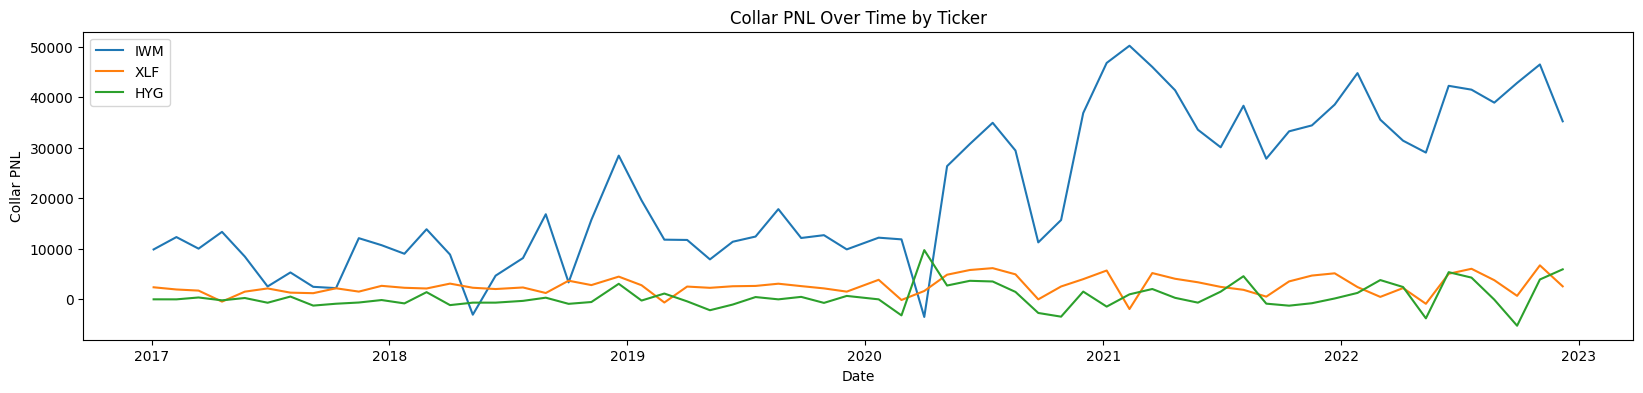

In [92]:
plt.figure(figsize=(20,4))
grouped = collar_df.groupby(['ticker'])
for ticker in collar_df.ticker.unique():
    ticker_df = grouped.get_group(ticker)
    plt.plot(ticker_df.date, ticker_df.trade_PNL, label =ticker)
    plt.legend()

plt.title('Collar PNL Over Time by Ticker')
plt.xlabel('Date')
plt.ylabel('Collar PNL')
plt.show()
plt.show()

In [42]:
total_pnl = collar_df.collar_price.sum() + collar_df.option_settlement.sum()
print(f"Total PNL: {total_pnl}")

Total PNL: 1532607.11


In [43]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = pd.DataFrame(index=['Option Collar Return'])
    summary_stats['annualized dollar return'] = return_data.mean()*12
    summary_stats['Annualized Volatility'] = return_data.std() *np.sqrt(12)
    summary_stats['Annualized Sharpe Ratio'] = summary_stats['annualized dollar return']/summary_stats['Annualized Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    return summary_stats

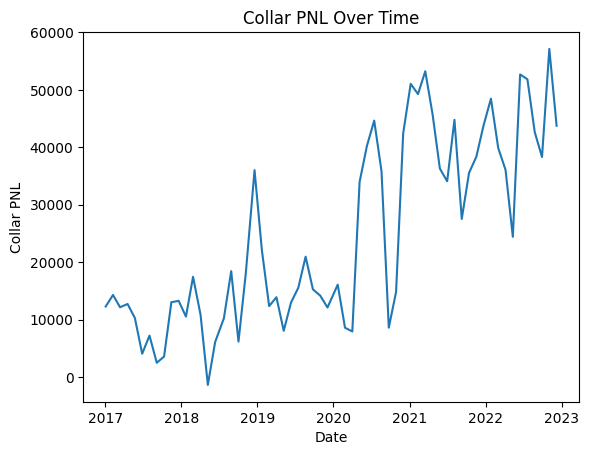

In [84]:
grouped = collar_df.groupby('date').trade_PNL.sum()
plt.plot(grouped)
plt.title('Collar PNL Over Time')
plt.xlabel('Date')
plt.ylabel('Collar PNL')
plt.show()

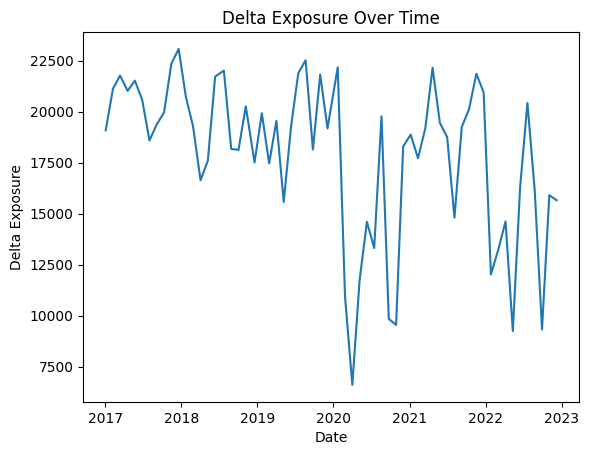

In [113]:
grouped = collar_df.groupby('date').delta_exposure.sum()
plt.plot(grouped)
plt.title('Delta Exposure Over Time')
plt.xlabel('Date')
plt.ylabel('Delta Exposure')
plt.show()

In [45]:
performance_summary(grouped)

,annualized dollar return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max
Option Collar Return,296640.096774,56908.572298,5.212573,0.381372,-1.299157,4140.575,2164.5,-1390.5,57124.5
